# 21-01 주제분석 3주차 패키지
#### 주혜인

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

- 이번주에 다룰 내용은 머신러닝 모델의 해석/기본적인 딥러닝입니다.
- 더불어서 다뤄지지는 내용은 randomness control입니다.
- 먼저 주어진 코드를 실행하세요.

In [2]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

## 1. Interpretable ML

해석가능한 머신러닝은 모델의 결과를 해석하기 위한 방법들입니다. 보통 랜덤포레스트(Random Forest)에서 Feature(Variable) Importance에 대해 들어본 적이 있을텐데, 그것과 유사합니다. Interpretable ML 방법의 특징은 어떤 모델에도 다 적용이 가능하다는건데, SVM이나 Neural Net같이 해석이 불가능하다고 알려진 모델들도 어떤 변수들이 모델을 만드는데 있어서 주요하게 사용되었는지를 파악할 수 있게 해줍니다. 물론 회귀분석처럼 '다른 변수들을 고정시킨 상황에서 $x_1$이 한단위 증가하면 $y$가 평균적으로 $\beta_1$만큼 증가한다' 라고 말할수는 없지만요!

Feature Importance/Partial Dependence Plot/Lime/SHAP 에 대한 해석은 조금 조심해야할 필요가 있습니다. 밑의 링크의 '모델해석 및 이탈원인 분석'을 참고하면 되는데, 처음에 딱 이해하기 쉬운 개념은 아니지만 나중에 보다보면 더 이해가 잘 되실 것 같아요.

https://danbi-ncsoft.github.io/competition/2019/02/19/big-contest-2018-retrospect.html

나중에 관심있으시면 이 책을 보는 것을 추천드립니다. 저도 아직 안봄 ㅎ

https://christophm.github.io/interpretable-ml-book/

#### **오늘의 해석은 각각 방법에 입각해서 엄밀하게 해석할 필요없이, 그냥 가볍게 해석해주시면 됩니다!**

### 1.1 모델 불러오기

주어진 패키지를 불러오고, `lgbm.pkl`을 불러오세요.

In [3]:
import pickle
import joblib

In [4]:
lgbm_loaded = pd.read_pickle('lgbm.pkl')

### 1.2 Feature Importance 확인과 해석

- 불러온 모델에 대해 `plot_importance`함수를 통해 Feature Importance를 시각화해주세요.
- 결과에 대해 간단히 해석해주세요.

여기서 Feature Importance는 Permutation를 통한 중요도를 보는 것이 아니고, tree 모델 자체의 구성에서 어떤 변수가 지니불순도를 잘 줄였는지를 확인한 것이라고 이해해주시면 됩니다. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

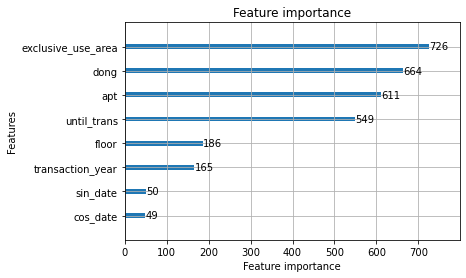

In [5]:
lgb.plot_importance(lgbm_loaded)

#### 해석 
    exclusice_use_area가 가장 잘 지니불순도를 줄였고 sin_sate와 cos_date 이 두 변수는 비슷한 수준으로 가장 지니불순도를 잘 줄이지 못했다. 지니불순도란? 클래스안에 완벽하게 잘 분류가 되변 공식에 따라 값이 0이된다.

**이제는 불러온 모델 말고, `best_lgbm_reg`를 사용하세요.**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

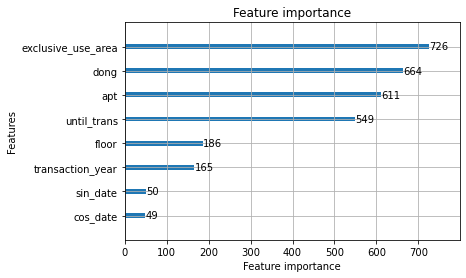

In [6]:
lgb.plot_importance(best_lgbm_reg)

### 1.3 Randomness Control

- `random, numpy` 패키지의 난수를 42로 고정하세요.
- 더불어서 `os` 패키지의 난수도 고정해야합니다.

Permutation 방식의 Feature Importance를 시행한건데, permutation자체에 랜덤성이 있다보니 결과가 재현 가능하도록 시드를 고정해줍니다.

파이썬의 시드 고정은 R처럼 그냥 `set.seed()`한다고 해서 고정되지 않습니다. 전체 파이썬과 여러 패키지들의 randomness를 각각 고정해주어야 재현가능해집니다. 정말 귀찮고, 딥러닝의 경우 GPU를 사용할 경우 GPU의 계산과 관련된 시드를 고정하면 속도가 상당히 느려진다고 알려져 있습니다. 더불어서 재현도 100%되진 않으며 성능도 살짝 떨어진다고는 하지만, GPU를 사용하지 않는 경우에는 문제가 없고 최소한 할줄은 알아야겠죠?

더불어서 왜 저런식으로 복잡하게 구성이 되는가?에 대해 궁금할 수 있는데 찾아본 적은 없지만 아마도 `numpy`는 c++가 뒤에서 연산을 해주는 것으로 알고있고(그래서 빠름!), `random`은 그냥 파이썬이고, `os`는 우리 os를 건드리는 것이 아닐까....? 추측입니다 :)

In [7]:
import random
import os
import tensorflow as tf

In [8]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

In [9]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [10]:
seed_everything(config.seed)

### 1.4 Permutation Feature Importance

- permutation feature importance를 계산하기 위해 `best_lgbm_reg`를 `permutation_importance`함수를 사용해 test set에 적합하세요.
- permutation feature importance를 시각화해주세요.

위의 1.2에서는 train에서 변수중요도를 보고, 지금은 test에서 봐서 좀 이상하다고 생각할수도 있습니다. 편의를 위해, 그리고 실제로 변수중요도에 대한 부분에서 어떤 set에 대해 봐야하는지가 100% 정답처럼 있는 것은 아니라고 알고 있어요.(물론 제가 틀렸을수도!) 아무튼 너무 신경쓰지말고 해주세요!

#### permutation feature importance란?
일단 모델피팅이 끝난 뒤에 계산, 그래서 만들어진 모델 변경 불가, target 변경불가.
데이터의 한 column을 무작위로 섞고 대상과 다른 모든 열은 고정시키면, 예측정확도는 어떻게 될까-> 예측에 크게 기여했던 열을 섞으면 모델 정확도가 확 떨어질듯
실제 target값을 이용하여 손실함수가 permutation으로 얼마나 깎였는지 계산하는거다. 이걸로 중요성을 알듯.


In [11]:
from sklearn.inspection import permutation_importance

In [12]:
results = permutation_importance(best_lgbm_reg, test_cbe, test_y)

<BarContainer object of 8 artists>

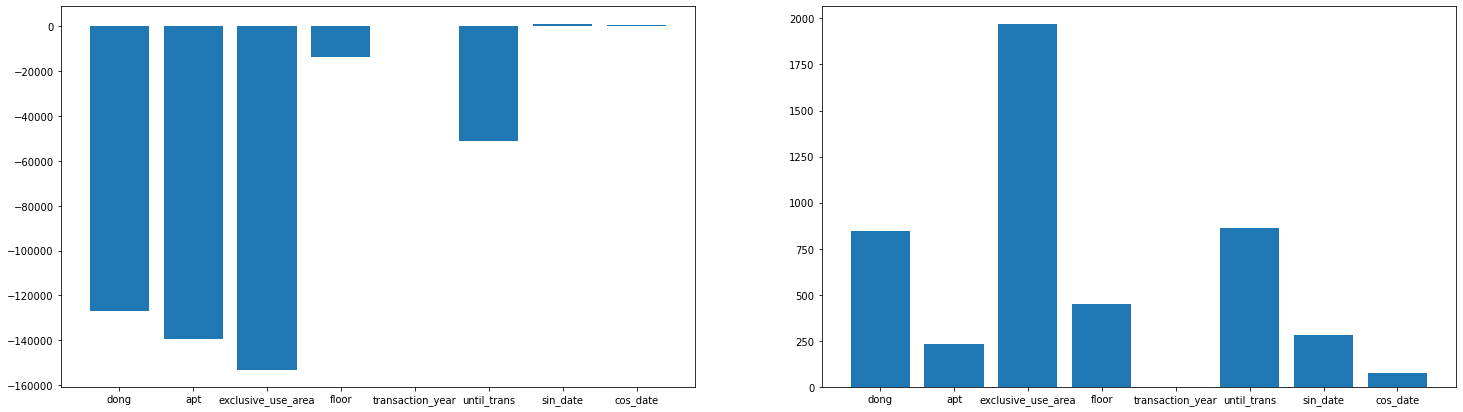

In [13]:
firstplot = plt.figure(figsize=(25,7))
axes1 = firstplot.add_subplot(1, 2, 1)
axes2 = firstplot.add_subplot(1, 2, 2)


axes1.bar(test_cbe.columns, results['importances_mean'])
axes2.bar(test_cbe.columns, results['importances_std'])
#음수? 음수는 셔플된 데이터가 원래 데이터보다 예측이 더 잘 된경우라는데 test set에 해서 이상할 수 있다는것이 바로 이런거였을까 내가 잘못한걸까?

### 1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석

- SHAP Value를 구하고 간단한 해석을 해주세요.
- `shap.TreeExplainer`, `shap_values`, `shap.summary_plot` 정도의 함수만 사용하면 됩니다.
- 결과가 좀 다른건 상관없습니다.

In [14]:
#! pip install shap

In [15]:
import shap

In [16]:
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)

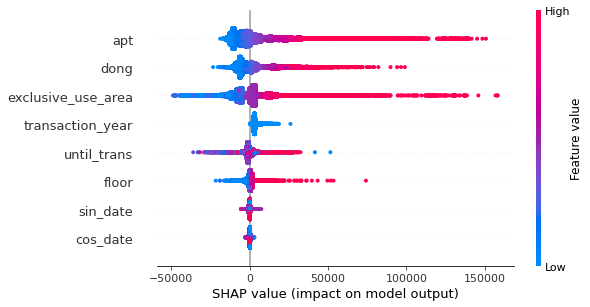

In [17]:
shap.summary_plot(shap_values,test_cbe)

이 플랏은 모든 변수들의 shap value를 요약한것입니다.
빨간색은 양의 영향력을, 파란색 음의 영향력을 나타낸다고 보면 됩니다. 먼저 가장 아래 삼각변환했던 sin_date랑 cos_date는 별로 양방향 모두 미미해보입니다. 맨 위에서 세 변수들 (apt,dong,exclusive_use_area)는 양의 영향력이 크다고 할 수 있겠습니다. 이와 반대로 transaction_year는 음의 영향력을 미치것으로 보입니다.

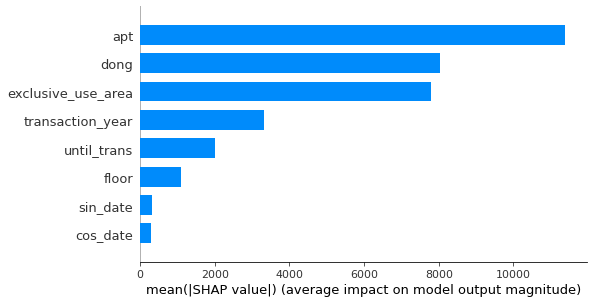

In [18]:
shap.summary_plot(shap_values,test_cbe, plot_type = "bar")

## 2. 딥러닝 기본

딥러닝 정말 간단히 해볼겁니다!

### 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.

In [19]:
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [20]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [21]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


### 해석

위 신경망은 활성화함수로 relu(안정적인 학습이 가능하고 기울기 소실 문제를 어느정도 해결가능)함수를 활성화함수로 사용하였습니다. 또한 최종 output의 길이는 1개로 가격을 예측하는 모델이겠지요..이 신경망의 입력층의 노드는 256개, 첫번째 은닉층의 노드는 64개, 두번째 은닉층의 노드는 32개입니다. 학습을 위한 손실함수로는 mse가 쓰이고 있습니다. 옵티마이저는 rmsprop 알고리즘을 사용하였습니다. 기울기 강하의 속도를 증가시키는 알고리즘이네요. 파라미터는 기본 값을 사용하는게 좋다고 한걸 어디서 봤는데 정말인지 모르겠네요~~.

### 2.2 training loss와 validation loss를 시각화하세요.

- 본인 컴에서 돌리면 꽤나 돌아갈수도 있어요. 주분과 함께하려면 패키지가 코랩으로 가거나, 주분이 코랩으로 가면 한번에 투 컴을 돌릴 수 있습니다.

In [23]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 5s 6ms/step - loss: 1042179848.1569 - mse: 1042179848.1569 - val_loss: 330068928.0000 - val_mse: 330068928.0000
Epoch 2/300
611/611 [==============================] - 2s 3ms/step - loss: 231198094.4052 - mse: 231198094.4052 - val_loss: 337552064.0000 - val_mse: 337552064.0000
Epoch 3/300
611/611 [==============================] - 2s 3ms/step - loss: 228201595.3203 - mse: 228201595.3203 - val_loss: 328827968.0000 - val_mse: 328827968.0000
Epoch 4/300
611/611 [==============================] - 2s 2ms/step - loss: 234408286.2222 - mse: 234408286.2222 - val_loss: 334935776.0000 - val_mse: 334935776.0000
Epoch 5/300
611/611 [==============================] - 2s 3ms/step - loss: 229916342.5098 - mse: 229916342.5098 - val_loss: 337564704.0000 - val_mse: 337564704.0000
Epoch 6/300
611/611 [==============================] - 2s 3ms/step - loss: 230344627.2941 - mse: 230344627.2941 - val_loss: 341206624.0000 - val_mse: 341206624.0000
Epoch 7/

611/611 [==============================] - 2s 3ms/step - loss: 186918988.0784 - mse: 186918988.0784 - val_loss: 294848224.0000 - val_mse: 294848224.0000
Epoch 51/300
611/611 [==============================] - 2s 3ms/step - loss: 197525598.5882 - mse: 197525598.5882 - val_loss: 352768288.0000 - val_mse: 352768288.0000
Epoch 52/300
611/611 [==============================] - 2s 3ms/step - loss: 188187976.9935 - mse: 188187976.9935 - val_loss: 336855904.0000 - val_mse: 336855904.0000
Epoch 53/300
611/611 [==============================] - 2s 3ms/step - loss: 192250091.6863 - mse: 192250091.6863 - val_loss: 273733152.0000 - val_mse: 273733152.0000
Epoch 54/300
611/611 [==============================] - 2s 3ms/step - loss: 190643840.2614 - mse: 190643840.2614 - val_loss: 386399072.0000 - val_mse: 386399072.0000
Epoch 55/300
611/611 [==============================] - 2s 3ms/step - loss: 193986462.1961 - mse: 193986462.1961 - val_loss: 275915616.0000 - val_mse: 275915616.0000
Epoch 56/300
611/

611/611 [==============================] - 2s 3ms/step - loss: 182162628.5752 - mse: 182162628.5752 - val_loss: 330244992.0000 - val_mse: 330244992.0000
Epoch 100/300
611/611 [==============================] - 2s 3ms/step - loss: 172687750.8497 - mse: 172687750.8497 - val_loss: 267186592.0000 - val_mse: 267186592.0000
Epoch 101/300
611/611 [==============================] - 2s 3ms/step - loss: 172656555.0850 - mse: 172656555.0850 - val_loss: 275335776.0000 - val_mse: 275335776.0000
Epoch 102/300
611/611 [==============================] - 2s 3ms/step - loss: 180842862.0915 - mse: 180842862.0915 - val_loss: 298362432.0000 - val_mse: 298362432.0000
Epoch 103/300
611/611 [==============================] - 2s 3ms/step - loss: 178869225.2026 - mse: 178869225.2026 - val_loss: 341624224.0000 - val_mse: 341624224.0000
Epoch 104/300
611/611 [==============================] - 2s 3ms/step - loss: 181571193.3856 - mse: 181571193.3856 - val_loss: 286399424.0000 - val_mse: 286399424.0000
Epoch 105/30

611/611 [==============================] - 2s 3ms/step - loss: 172138854.2614 - mse: 172138854.2614 - val_loss: 242639168.0000 - val_mse: 242639168.0000
Epoch 149/300
611/611 [==============================] - 2s 3ms/step - loss: 174649227.7778 - mse: 174649227.7778 - val_loss: 246802144.0000 - val_mse: 246802144.0000
Epoch 150/300
611/611 [==============================] - 2s 3ms/step - loss: 178050816.0000 - mse: 178050816.0000 - val_loss: 291760032.0000 - val_mse: 291760032.0000
Epoch 151/300
611/611 [==============================] - 2s 3ms/step - loss: 173799423.6078 - mse: 173799423.6078 - val_loss: 362060384.0000 - val_mse: 362060384.0000
Epoch 152/300
611/611 [==============================] - 2s 3ms/step - loss: 177178535.5033 - mse: 177178535.5033 - val_loss: 360116320.0000 - val_mse: 360116320.0000
Epoch 153/300
611/611 [==============================] - 2s 3ms/step - loss: 176544007.2418 - mse: 176544007.2418 - val_loss: 294595776.0000 - val_mse: 294595776.0000
Epoch 154/30

611/611 [==============================] - 2s 3ms/step - loss: 171542172.4444 - mse: 171542172.4444 - val_loss: 242752720.0000 - val_mse: 242752720.0000
Epoch 198/300
611/611 [==============================] - 2s 3ms/step - loss: 173341557.2810 - mse: 173341557.2810 - val_loss: 270045376.0000 - val_mse: 270045376.0000
Epoch 199/300
611/611 [==============================] - 2s 3ms/step - loss: 174724072.4444 - mse: 174724072.4444 - val_loss: 253682304.0000 - val_mse: 253682304.0000
Epoch 200/300
611/611 [==============================] - 2s 3ms/step - loss: 178229180.8235 - mse: 178229180.8235 - val_loss: 283107488.0000 - val_mse: 283107488.0000
Epoch 201/300
611/611 [==============================] - 2s 3ms/step - loss: 171643827.8170 - mse: 171643827.8170 - val_loss: 333279392.0000 - val_mse: 333279392.0000
Epoch 202/300
611/611 [==============================] - 2s 3ms/step - loss: 171618050.5882 - mse: 171618050.5882 - val_loss: 293250944.0000 - val_mse: 293250944.0000
Epoch 203/30

611/611 [==============================] - 2s 3ms/step - loss: 168286294.1438 - mse: 168286294.1438 - val_loss: 279464608.0000 - val_mse: 279464608.0000
Epoch 247/300
611/611 [==============================] - 2s 3ms/step - loss: 166764237.7386 - mse: 166764237.7386 - val_loss: 270838880.0000 - val_mse: 270838880.0000
Epoch 248/300
611/611 [==============================] - 2s 3ms/step - loss: 164222029.0327 - mse: 164222029.0327 - val_loss: 264100768.0000 - val_mse: 264100768.0000
Epoch 249/300
611/611 [==============================] - 2s 3ms/step - loss: 170321989.3856 - mse: 170321989.3856 - val_loss: 427084672.0000 - val_mse: 427084672.0000
Epoch 250/300
611/611 [==============================] - 2s 3ms/step - loss: 167869367.2157 - mse: 167869367.2157 - val_loss: 243797264.0000 - val_mse: 243797264.0000
Epoch 251/300
611/611 [==============================] - 2s 3ms/step - loss: 166508634.9542 - mse: 166508634.9542 - val_loss: 291488480.0000 - val_mse: 291488480.0000
Epoch 252/30

611/611 [==============================] - 3s 6ms/step - loss: 158936596.3660 - mse: 158936596.3660 - val_loss: 216285696.0000 - val_mse: 216285696.0000
Epoch 296/300
611/611 [==============================] - 2s 4ms/step - loss: 158563382.8366 - mse: 158563382.8366 - val_loss: 310335744.0000 - val_mse: 310335744.0000
Epoch 297/300
611/611 [==============================] - 2s 3ms/step - loss: 165329467.6340 - mse: 165329467.6340 - val_loss: 253393552.0000 - val_mse: 253393552.0000
Epoch 298/300
611/611 [==============================] - 2s 3ms/step - loss: 155497240.3922 - mse: 155497240.3922 - val_loss: 247236960.0000 - val_mse: 247236960.0000
Epoch 299/300
611/611 [==============================] - 3s 4ms/step - loss: 162827969.0719 - mse: 162827969.0719 - val_loss: 230534352.0000 - val_mse: 230534352.0000
Epoch 300/300
611/611 [==============================] - 2s 3ms/step - loss: 162463464.5490 - mse: 162463464.5490 - val_loss: 295315232.0000 - val_mse: 295315232.0000


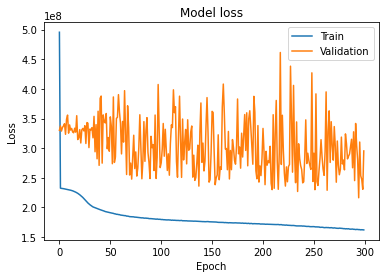

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### 2.3 어떤문제가 발생했는지 설명해주세요.

    학습이 진행될수록 training loss는 줄어들지만 test loss는 들쑥날쑥 변동이 심해 줄어들었다고 하기 힘든상황입니다. 또한, lgbm의validation mse가 그래프상으로 보기에 위 모델의 training loss의 최솟값보다도 크다고 할 수 있습니다. 따라서 이 모델의 성능이 우수하다고 할 수 없습니다. 

### 2.4 더 좋은 성능의 딥러닝 모델을 위해

- test set에 대해 딥러닝 모형의 성능을 평가하세요.
- dense 조절, batch_size 조절, regularization, dropout, batch normalization 등의 방법을 활용해 최고의 성능을 얻어보세요.
- 만약 성능의 향상이 어렵다면, 다양한 방법들을 시도하는 것을 목표로 해주세요!

In [25]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [26]:
model.fit(train_cbe, train_y, epochs=300, validation_data = (test_cbe, test_y), batch_size = 512)

Epoch 1/300
825/825 [==============================] - 3s 3ms/step - loss: 179516832.0000 - mse: 179516832.0000 - val_loss: 3056156160.0000 - val_mse: 3056156160.0000
Epoch 2/300
825/825 [==============================] - 3s 3ms/step - loss: 179359680.0000 - mse: 179359680.0000 - val_loss: 3187021056.0000 - val_mse: 3187021056.0000
Epoch 3/300
825/825 [==============================] - 3s 3ms/step - loss: 179015248.0000 - mse: 179015248.0000 - val_loss: 3894118144.0000 - val_mse: 3894118144.0000
Epoch 4/300
825/825 [==============================] - 2s 3ms/step - loss: 178802704.0000 - mse: 178802704.0000 - val_loss: 3176945152.0000 - val_mse: 3176945152.0000
Epoch 5/300
825/825 [==============================] - 3s 3ms/step - loss: 178747424.0000 - mse: 178747424.0000 - val_loss: 3649021696.0000 - val_mse: 3649021696.0000
Epoch 6/300
825/825 [==============================] - 3s 3ms/step - loss: 178199184.0000 - mse: 178199184.0000 - val_loss: 3829729792.0000 - val_mse: 3829729792.000

Epoch 50/300
825/825 [==============================] - 2s 3ms/step - loss: 171345280.0000 - mse: 171345280.0000 - val_loss: 3301855488.0000 - val_mse: 3301855488.0000
Epoch 51/300
825/825 [==============================] - 2s 3ms/step - loss: 170654496.0000 - mse: 170654496.0000 - val_loss: 4036785408.0000 - val_mse: 4036785408.0000
Epoch 52/300
825/825 [==============================] - 2s 3ms/step - loss: 171009984.0000 - mse: 171009984.0000 - val_loss: 3491276544.0000 - val_mse: 3491276544.0000
Epoch 53/300
825/825 [==============================] - 2s 3ms/step - loss: 170541616.0000 - mse: 170541616.0000 - val_loss: 3579579392.0000 - val_mse: 3579579392.0000
Epoch 54/300
825/825 [==============================] - 2s 3ms/step - loss: 170855856.0000 - mse: 170855856.0000 - val_loss: 3282632192.0000 - val_mse: 3282632192.0000
Epoch 55/300
825/825 [==============================] - 2s 3ms/step - loss: 170287088.0000 - mse: 170287088.0000 - val_loss: 3685881600.0000 - val_mse: 36858816

Epoch 99/300
825/825 [==============================] - 2s 3ms/step - loss: 165442064.0000 - mse: 165442064.0000 - val_loss: 3665655296.0000 - val_mse: 3665655296.0000
Epoch 100/300
825/825 [==============================] - 2s 3ms/step - loss: 165097472.0000 - mse: 165097472.0000 - val_loss: 4012092928.0000 - val_mse: 4012092928.0000
Epoch 101/300
825/825 [==============================] - 2s 3ms/step - loss: 165460528.0000 - mse: 165460528.0000 - val_loss: 3830432000.0000 - val_mse: 3830432000.0000
Epoch 102/300
825/825 [==============================] - 2s 3ms/step - loss: 165346224.0000 - mse: 165346224.0000 - val_loss: 3658049792.0000 - val_mse: 3658049792.0000
Epoch 103/300
825/825 [==============================] - 2s 3ms/step - loss: 165387376.0000 - mse: 165387376.0000 - val_loss: 3647022080.0000 - val_mse: 3647022080.0000
Epoch 104/300
825/825 [==============================] - 2s 3ms/step - loss: 164594688.0000 - mse: 164594688.0000 - val_loss: 3435444736.0000 - val_mse: 343

825/825 [==============================] - 2s 3ms/step - loss: 160831968.0000 - mse: 160831968.0000 - val_loss: 3395387904.0000 - val_mse: 3395387904.0000
Epoch 148/300
825/825 [==============================] - 2s 3ms/step - loss: 160611456.0000 - mse: 160611456.0000 - val_loss: 4114383872.0000 - val_mse: 4114383872.0000
Epoch 149/300
825/825 [==============================] - 2s 3ms/step - loss: 160732656.0000 - mse: 160732656.0000 - val_loss: 3552804864.0000 - val_mse: 3552804864.0000
Epoch 150/300
825/825 [==============================] - 2s 3ms/step - loss: 160102176.0000 - mse: 160102176.0000 - val_loss: 4156886784.0000 - val_mse: 4156886784.0000
Epoch 151/300
825/825 [==============================] - 2s 3ms/step - loss: 160191632.0000 - mse: 160191632.0000 - val_loss: 4073532160.0000 - val_mse: 4073532160.0000
Epoch 152/300
825/825 [==============================] - 2s 3ms/step - loss: 160240400.0000 - mse: 160240400.0000 - val_loss: 3103129344.0000 - val_mse: 3103129344.0000


825/825 [==============================] - 3s 4ms/step - loss: 155884144.0000 - mse: 155884144.0000 - val_loss: 4840114176.0000 - val_mse: 4840114176.0000
Epoch 196/300
825/825 [==============================] - 4s 5ms/step - loss: 155764432.0000 - mse: 155764432.0000 - val_loss: 4012786688.0000 - val_mse: 4012786688.0000
Epoch 197/300
825/825 [==============================] - 4s 5ms/step - loss: 156098208.0000 - mse: 156098208.0000 - val_loss: 4088218112.0000 - val_mse: 4088218112.0000
Epoch 198/300
825/825 [==============================] - 4s 5ms/step - loss: 155866784.0000 - mse: 155866784.0000 - val_loss: 3458439680.0000 - val_mse: 3458439680.0000
Epoch 199/300
825/825 [==============================] - 3s 4ms/step - loss: 155566752.0000 - mse: 155566752.0000 - val_loss: 3469691392.0000 - val_mse: 3469691392.0000
Epoch 200/300
825/825 [==============================] - 3s 4ms/step - loss: 156018640.0000 - mse: 156018640.0000 - val_loss: 3505827072.0000 - val_mse: 3505827072.0000


825/825 [==============================] - 2s 3ms/step - loss: 152546976.0000 - mse: 152546976.0000 - val_loss: 3273931008.0000 - val_mse: 3273931008.0000
Epoch 244/300
825/825 [==============================] - 2s 3ms/step - loss: 152133072.0000 - mse: 152133072.0000 - val_loss: 4361911296.0000 - val_mse: 4361911296.0000
Epoch 245/300
825/825 [==============================] - 2s 3ms/step - loss: 151932752.0000 - mse: 151932752.0000 - val_loss: 2870012928.0000 - val_mse: 2870012928.0000
Epoch 246/300
825/825 [==============================] - 2s 3ms/step - loss: 152232432.0000 - mse: 152232432.0000 - val_loss: 5026448384.0000 - val_mse: 5026448384.0000
Epoch 247/300
825/825 [==============================] - 2s 3ms/step - loss: 152601200.0000 - mse: 152601200.0000 - val_loss: 4435896320.0000 - val_mse: 4435896320.0000
Epoch 248/300
825/825 [==============================] - 2s 3ms/step - loss: 152170608.0000 - mse: 152170608.0000 - val_loss: 4016582656.0000 - val_mse: 4016582656.0000


825/825 [==============================] - 2s 3ms/step - loss: 149167952.0000 - mse: 149167952.0000 - val_loss: 4081893120.0000 - val_mse: 4081893120.0000
Epoch 292/300
825/825 [==============================] - 2s 3ms/step - loss: 149003504.0000 - mse: 149003504.0000 - val_loss: 3728784896.0000 - val_mse: 3728784896.0000
Epoch 293/300
825/825 [==============================] - 3s 4ms/step - loss: 149263840.0000 - mse: 149263840.0000 - val_loss: 3638479360.0000 - val_mse: 3638479360.0000
Epoch 294/300
825/825 [==============================] - 3s 3ms/step - loss: 148877968.0000 - mse: 148877968.0000 - val_loss: 3516352256.0000 - val_mse: 3516352256.0000
Epoch 295/300
825/825 [==============================] - 3s 3ms/step - loss: 148924336.0000 - mse: 148924336.0000 - val_loss: 2905019904.0000 - val_mse: 2905019904.0000
Epoch 296/300
825/825 [==============================] - 4s 5ms/step - loss: 149274032.0000 - mse: 149274032.0000 - val_loss: 2878117120.0000 - val_mse: 2878117120.0000


In [27]:
from keras.layers.normalization import BatchNormalization

In [28]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.BatchNormalization(),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [29]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

In [31]:
model.fit(train_cbe, train_y, epochs=300, validation_data = (test_cbe, test_y), batch_size = 512)

Epoch 1/300
825/825 [==============================] - 4s 5ms/step - loss: 3121773824.0000 - mse: 3121773824.0000 - val_loss: 1436199.6250 - val_mse: 1436199.6250
Epoch 2/300
825/825 [==============================] - 4s 5ms/step - loss: 3116705024.0000 - mse: 3116705024.0000 - val_loss: 5334593.5000 - val_mse: 5334593.5000
Epoch 3/300
825/825 [==============================] - 3s 4ms/step - loss: 3111481856.0000 - mse: 3111481856.0000 - val_loss: 491875.7812 - val_mse: 491875.7812
Epoch 4/300
825/825 [==============================] - 3s 4ms/step - loss: 3106619648.0000 - mse: 3106619648.0000 - val_loss: 2443816.2500 - val_mse: 2443816.2500
Epoch 5/300
825/825 [==============================] - 3s 4ms/step - loss: 3100835584.0000 - mse: 3100835584.0000 - val_loss: 21666624.0000 - val_mse: 21666624.0000
Epoch 6/300
825/825 [==============================] - 3s 4ms/step - loss: 3096119552.0000 - mse: 3096119552.0000 - val_loss: 520359.6562 - val_mse: 520359.6562
Epoch 7/300
825/825 [===

Epoch 51/300
825/825 [==============================] - 4s 5ms/step - loss: 2813785856.0000 - mse: 2813785856.0000 - val_loss: 13868130.0000 - val_mse: 13868130.0000
Epoch 52/300
825/825 [==============================] - 4s 5ms/step - loss: 2805960704.0000 - mse: 2805960704.0000 - val_loss: 3136015.0000 - val_mse: 3136015.0000
Epoch 53/300
825/825 [==============================] - 4s 5ms/step - loss: 2798366464.0000 - mse: 2798366464.0000 - val_loss: 73245680.0000 - val_mse: 73245680.0000
Epoch 54/300
825/825 [==============================] - 4s 5ms/step - loss: 2791757824.0000 - mse: 2791757824.0000 - val_loss: 6613432.0000 - val_mse: 6613432.0000
Epoch 55/300
825/825 [==============================] - 4s 5ms/step - loss: 2785708288.0000 - mse: 2785708288.0000 - val_loss: 68016672.0000 - val_mse: 68016672.0000
Epoch 56/300
825/825 [==============================] - 4s 4ms/step - loss: 2777272064.0000 - mse: 2777272064.0000 - val_loss: 22944742.0000 - val_mse: 22944742.0000
Epoch 57

825/825 [==============================] - 4s 5ms/step - loss: 2661300992.0000 - mse: 2661300992.0000 - val_loss: 59744128.0000 - val_mse: 59744128.0000
Epoch 101/300
825/825 [==============================] - 4s 5ms/step - loss: 2654618368.0000 - mse: 2654618368.0000 - val_loss: 61064444.0000 - val_mse: 61064444.0000
Epoch 102/300
825/825 [==============================] - 4s 5ms/step - loss: 2647922432.0000 - mse: 2647922432.0000 - val_loss: 62383236.0000 - val_mse: 62383236.0000
Epoch 103/300
825/825 [==============================] - 4s 5ms/step - loss: 2641212160.0000 - mse: 2641212160.0000 - val_loss: 63722708.0000 - val_mse: 63722708.0000
Epoch 104/300
825/825 [==============================] - 4s 5ms/step - loss: 2634467328.0000 - mse: 2634467328.0000 - val_loss: 65083748.0000 - val_mse: 65083748.0000
Epoch 105/300
825/825 [==============================] - 4s 5ms/step - loss: 2627714048.0000 - mse: 2627714048.0000 - val_loss: 66466628.0000 - val_mse: 66466628.0000
Epoch 106/30

Epoch 149/300
825/825 [==============================] - 4s 5ms/step - loss: 2314000640.0000 - mse: 2314000640.0000 - val_loss: 152103312.0000 - val_mse: 152103312.0000
Epoch 150/300
825/825 [==============================] - 4s 5ms/step - loss: 2306580736.0000 - mse: 2306580736.0000 - val_loss: 154698352.0000 - val_mse: 154698352.0000
Epoch 151/300
825/825 [==============================] - 4s 5ms/step - loss: 2299161088.0000 - mse: 2299161088.0000 - val_loss: 157327312.0000 - val_mse: 157327312.0000
Epoch 152/300
825/825 [==============================] - 4s 4ms/step - loss: 2291723520.0000 - mse: 2291723520.0000 - val_loss: 159988304.0000 - val_mse: 159988304.0000
Epoch 153/300
825/825 [==============================] - 4s 4ms/step - loss: 2284273152.0000 - mse: 2284273152.0000 - val_loss: 162684432.0000 - val_mse: 162684432.0000
Epoch 154/300
825/825 [==============================] - 4s 5ms/step - loss: 2276830208.0000 - mse: 2276830208.0000 - val_loss: 165410976.0000 - val_mse: 1

825/825 [==============================] - 4s 5ms/step - loss: 1952984448.0000 - mse: 1952984448.0000 - val_loss: 318694496.0000 - val_mse: 318694496.0000
Epoch 198/300
825/825 [==============================] - 4s 5ms/step - loss: 1945479296.0000 - mse: 1945479296.0000 - val_loss: 323193568.0000 - val_mse: 323193568.0000
Epoch 199/300
825/825 [==============================] - 5s 6ms/step - loss: 1937970688.0000 - mse: 1937970688.0000 - val_loss: 327742592.0000 - val_mse: 327742592.0000
Epoch 200/300
825/825 [==============================] - 5s 6ms/step - loss: 1930470656.0000 - mse: 1930470656.0000 - val_loss: 332338880.0000 - val_mse: 332338880.0000
Epoch 201/300
825/825 [==============================] - 6s 7ms/step - loss: 1922971392.0000 - mse: 1922971392.0000 - val_loss: 336981856.0000 - val_mse: 336981856.0000
Epoch 202/300
825/825 [==============================] - 4s 5ms/step - loss: 1915483648.0000 - mse: 1915483648.0000 - val_loss: 341672544.0000 - val_mse: 341672544.0000


825/825 [==============================] - 4s 5ms/step - loss: 1604753536.0000 - mse: 1604753536.0000 - val_loss: 593837376.0000 - val_mse: 593837376.0000
Epoch 246/300
825/825 [==============================] - 4s 5ms/step - loss: 1597900928.0000 - mse: 1597900928.0000 - val_loss: 600991488.0000 - val_mse: 600991488.0000
Epoch 247/300
825/825 [==============================] - 4s 5ms/step - loss: 1591085184.0000 - mse: 1591085184.0000 - val_loss: 608210496.0000 - val_mse: 608210496.0000
Epoch 248/300
825/825 [==============================] - 4s 5ms/step - loss: 1584280704.0000 - mse: 1584280704.0000 - val_loss: 615493056.0000 - val_mse: 615493056.0000
Epoch 249/300
825/825 [==============================] - 4s 5ms/step - loss: 1577486336.0000 - mse: 1577486336.0000 - val_loss: 622843136.0000 - val_mse: 622843136.0000
Epoch 250/300
825/825 [==============================] - 4s 5ms/step - loss: 1570729984.0000 - mse: 1570729984.0000 - val_loss: 630256448.0000 - val_mse: 630256448.0000


825/825 [==============================] - 4s 5ms/step - loss: 1308498048.0000 - mse: 1308498048.0000 - val_loss: 1016058560.0000 - val_mse: 1016058560.0000
Epoch 294/300
825/825 [==============================] - 4s 4ms/step - loss: 1303193984.0000 - mse: 1303193984.0000 - val_loss: 1026713664.0000 - val_mse: 1026713664.0000
Epoch 295/300
825/825 [==============================] - 4s 4ms/step - loss: 1297936640.0000 - mse: 1297936640.0000 - val_loss: 1037441728.0000 - val_mse: 1037441728.0000
Epoch 296/300
825/825 [==============================] - 4s 4ms/step - loss: 1292717184.0000 - mse: 1292717184.0000 - val_loss: 1048267136.0000 - val_mse: 1048267136.0000
Epoch 297/300
825/825 [==============================] - 3s 4ms/step - loss: 1287534720.0000 - mse: 1287534720.0000 - val_loss: 1059169920.0000 - val_mse: 1059169920.0000
Epoch 298/300
825/825 [==============================] - 3s 4ms/step - loss: 1282402176.0000 - mse: 1282402176.0000 - val_loss: 1070171008.0000 - val_mse: 1070

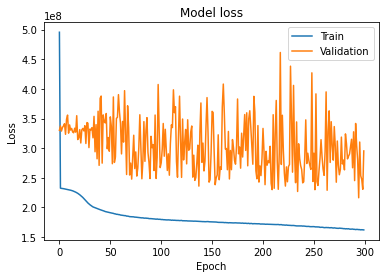

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()